# POWER AND CUPED

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from ab_testing import per_user_gpv, run_frequentist
from metrics import compute_gpv
from analyze import diff_in_means_crse, cuped_transform

In [3]:
data_path = os.path.join(project_root, 'data')

# Load data
sessions = pd.read_csv(os.path.join(data_path, 'sessions.csv'))
orders = pd.read_csv(os.path.join(data_path, 'orders.csv'))
users = pd.read_csv(os.path.join(data_path, 'users.csv'))
assignments = pd.read_csv(os.path.join(data_path, 'assignments.csv'))
perf = pd.read_csv(os.path.join(data_path, 'perf.csv'))
events = pd.read_csv(os.path.join(data_path, 'events.csv'))


# Merge sessions with assignments
sessions = sessions.merge(assignments[['user_id', 'variant']], on='user_id', how='left')

# Aggregate per-user GPV
# The function per_user_gpv requires the assignments table as an argument.
# This corrects the TypeError.
df = per_user_gpv(sessions, orders, assignments)

# Merge past_7d_gpv from the users table
df['past_7d_gpv'] = df['user_id'].map(users.set_index('user_id')['past_7d_gpv'])

# Drop rows with NaNs in key columns, in this case, users that were not
# part of the experiment (e.g., control or treatment) will have a NaN
# as they will not be assigned a variant.
df.dropna(subset=['variant','past_7d_gpv'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
# Run frequentist analysis with CUPED
res_freq = run_frequentist(df)
df_cuped = res_freq['df_cuped']

print("\nFrequentist Analysis Results (with CUPED):")
print(f"Lift: {res_freq['lift']:.4f}")
print(f"p-value: {res_freq['p']:.4f}")
print(f"Confidence Interval: [{res_freq['ci_low']:.4f}, {res_freq['ci_high']:.4f}]")
print(f"Variance reduction (theta): {res_freq['theta']:.4f}")


Frequentist Analysis Results (with CUPED):
Lift: 7.5458
p-value: 0.0008
Confidence Interval: [3.1151, 11.9765]
Variance reduction (theta): 0.1394


In [5]:
# Power / sample size illustration
alpha = 0.05
# Calculate observed effect size using CUPED-adjusted data
effect_size = (df_cuped.loc[df_cuped['variant']=='treatment','gpv_cuped'].mean() - df_cuped.loc[df_cuped['variant']=='control','gpv_cuped'].mean()) / np.std(df_cuped['gpv_cuped'])

power_analysis = TTestIndPower()
required_n = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=alpha, ratio=1.0)
print(f"\nRequired n per group for 80% power: {required_n:.0f}")


Required n per group for 80% power: 360


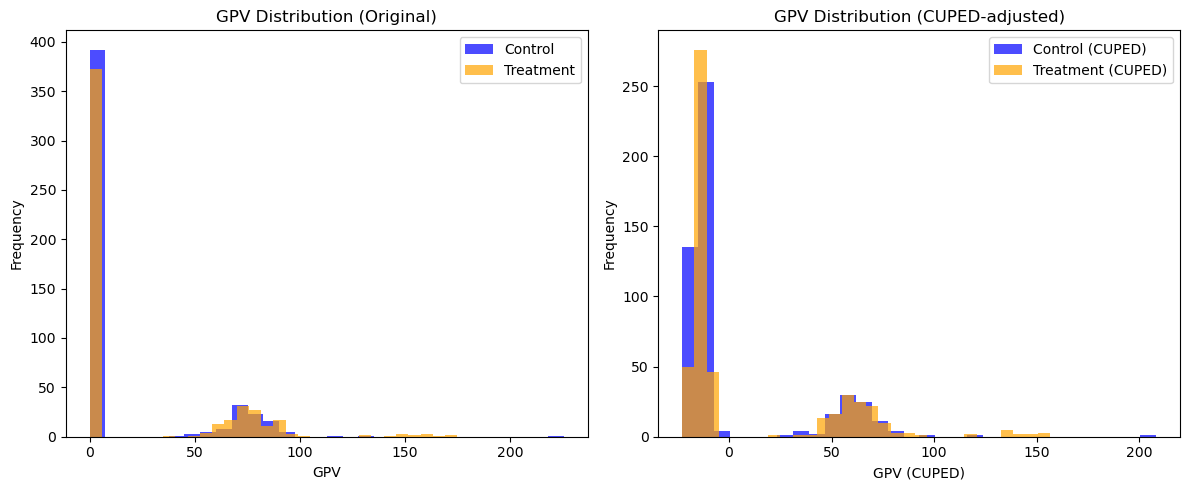

In [6]:
# Visualization: GPV distribution
plt.figure(figsize=(12, 5))

# Original GPV distribution
plt.subplot(1, 2, 1)
plt.hist(df.loc[df['variant'] == 'control', 'gpv'], bins=30, alpha=0.7, label='Control', color='blue')
plt.hist(df.loc[df['variant'] == 'treatment', 'gpv'], bins=30, alpha=0.7, label='Treatment', color='orange')
plt.title("GPV Distribution (Original)")
plt.xlabel("GPV")
plt.ylabel("Frequency")
plt.legend()

# CUPED-adjusted GPV distribution
plt.subplot(1, 2, 2)
plt.hist(df_cuped.loc[df_cuped['variant'] == 'control', 'gpv_cuped'], bins=30, alpha=0.7, label='Control (CUPED)', color='blue')
plt.hist(df_cuped.loc[df_cuped['variant'] == 'treatment', 'gpv_cuped'], bins=30, alpha=0.7, label='Treatment (CUPED)', color='orange')
plt.title("GPV Distribution (CUPED-adjusted)")
plt.xlabel("GPV (CUPED)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()